In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
import numpy as np

from cleverhans.attacks import FastGradientMethod
from cleverhans.dataset import MNIST
from cleverhans.loss import CrossEntropy
from cleverhans.train import train
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import cnn_model
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval

/vulcanscratch/psando/envs/tf-gduap/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/vulcanscratch/psando/envs/tf-gduap/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/vulcanscratch/psando/envs/tf-gduap/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/vulcanscratch/psando/envs/tf-gduap/l

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# Check GPU availability
print(f"GPU Available: {tf.test.is_gpu_available()}")
print(f"GPU Name: {tf.test.gpu_device_name()}")

GPU Available: True
GPU Name: /device:GPU:0


In [4]:
tf.keras.backend.set_learning_phase(0)
tf.set_random_seed(1)
# Create TF session and set as Keras backend session
sess = tf.Session()
keras.backend.set_session(sess)

In [5]:
# Get MNIST test data
train_start=0
train_end=60000
test_start=0
test_end=10000

mnist = MNIST(train_start=train_start, train_end=train_end,
              test_start=test_start, test_end=test_end)
x_train, y_train = mnist.get_set('train')
x_test, y_test = mnist.get_set('test')

# Obtain Image Parameters
img_rows, img_cols, nchannels = x_train.shape[1:4]
nb_classes = y_train.shape[1]

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols,
                                    nchannels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

# Define TF model graph
model = cnn_model(img_rows=img_rows, img_cols=img_cols,
                  channels=nchannels, nb_filters=64,
                  nb_classes=nb_classes)
preds = model(x)
print("Defined TensorFlow model graph.")
wrap = KerasModelWrapper(model)

Defined TensorFlow model graph.


In [6]:
NB_EPOCHS = 1
BATCH_SIZE = 128
LEARNING_RATE = .001
TRAIN_DIR = 'train_dir'
FILENAME = 'mnist.ckpt'

def evaluate():
    # Evaluate the accuracy of the MNIST model on legitimate test examples
    eval_params = {'batch_size': BATCH_SIZE}
    acc = model_eval(sess, x, y, preds, x_test, y_test, args=eval_params)
#     report.clean_train_clean_eval = acc
#     assert X_test.shape[0] == test_end - test_start, X_test.shape
    print('Test accuracy on legitimate examples: %0.4f' % acc)

In [7]:
train_params = {
  'nb_epochs': NB_EPOCHS,
  'batch_size': BATCH_SIZE,
  'learning_rate': LEARNING_RATE,
  'train_dir': TRAIN_DIR,
  'filename': FILENAME
}

rng = np.random.RandomState([2017, 8, 30])
label_smoothing=0.1
loss = CrossEntropy(wrap, smoothing=label_smoothing)
train(sess, loss, x_train, y_train, evaluate=evaluate,
      args=train_params, rng=rng)

num_devices:  1


[INFO 2020-11-24 00:31:27,522 cleverhans] Epoch 0 took 3.4043843746185303 seconds


Test accuracy on legitimate examples: 0.9865


True

In [8]:
# Initialize the Fast Gradient Sign Method (FGSM) attack object and graph
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.3,
             'clip_min': 0.,
             'clip_max': 1.}
adv_x = fgsm.generate(x, **fgsm_params)
# Consider the attack to be constant
adv_x = tf.stop_gradient(adv_x)
preds_adv = model(adv_x)

# Evaluate the accuracy of the MNIST model on adversarial examples
eval_par = {'batch_size': BATCH_SIZE}
acc = model_eval(sess, x, y, preds_adv, x_test, y_test, args=eval_par)
print('Test accuracy on adversarial examples: %0.4f\n' % acc)

Test accuracy on adversarial examples: 0.0392



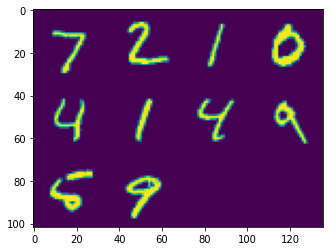

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from cleverhans.plot.image import show, make_grid

# Plot original images
image_batch = x_test[0:10]
grid = make_grid(image_batch)
plt.imshow(grid)